<a href="https://colab.research.google.com/github/Brijeshtanwar/Topic-Modeling/blob/main/sklearn_nlp_fasttext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# NLP libraries
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [173]:
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [174]:
url = """https://raw.githubusercontent.com/Brijeshtanwar/Topic-Modeling/main/voc_data.csv"""
df = pd.read_csv(url,  encoding = 'unicode_escape')

In [175]:
df = df[['CUSTOMER COMMENT', 'Reason']]
df.columns = ['comment', 'topic']

In [176]:
df.isnull().sum()

comment    0
topic      0
dtype: int64

In [177]:
# Drop na 
df.dropna(axis=0, inplace=True)

In [178]:
df.topic.value_counts()

Service                      1570
APPLICATION (WEB/APP)        1074
SERVICE                       335
CHARGES(BRO./DP/LPC ETC.)     332
Others                        321
NOT SPECIFIED                 254
Not Specified                 216
People                        113
Process                        69
PEOPLE                         32
Product                        13
PROCESS                         6
Name: topic, dtype: int64

In [179]:
#lower case
df['topic'] = df['topic'].str.lower()
df['topic'] = df['topic'].str.strip()
df.loc[df.topic=='not specified', 'topic'] = 'others'

In [180]:
df.topic.unique()

array(['service', 'application (web/app)', 'others',
       'charges(bro./dp/lpc etc.)', 'process', 'people', 'product'],
      dtype=object)

In [181]:
topic_dic = {'application (web/app)': 'application',  'charges(bro./dp/lpc etc.)': 'charges', 'service':'service'
, 'others':'others', 'process':'process', 'people':'people', 'product':'product'}

In [182]:
df['topic'] = df['topic'].map(topic_dic)

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='count', ylabel='topic'>

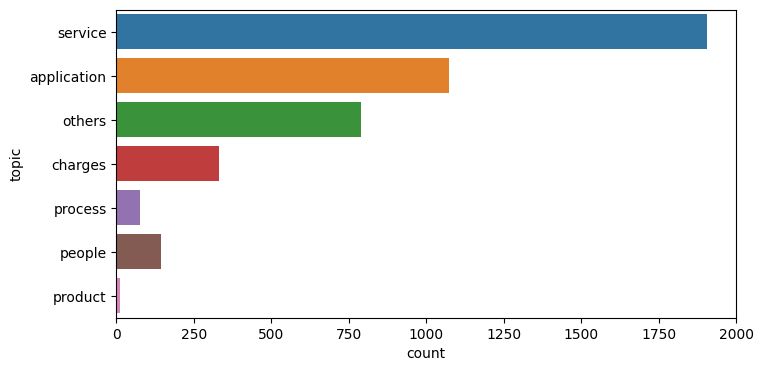

In [183]:
plt.figure(figsize=[8,4])
sns.countplot(y=df['topic'])

In [184]:
# Preprocessing

In [185]:
# Remove integer comments
df = df[df['comment'].apply(lambda x: not isinstance(x, int))]
df.reset_index(drop=True, inplace=True)

#lower case
df['comment'] = df['comment'].str.lower()

In [186]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and  characters and then strip)
    text = re.sub(r"[^A-Za-z]+", ' ' , str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    # if lst_stopwords is not None:
    #     lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [187]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords.remove('no')
lst_stopwords.remove('not')

In [188]:
df["x"] = df["comment"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
# df['x'] = df['comment']
df['y'] = df['topic']
df.head(10)

,comment,topic,x,y
0,querries where kotak is at disadvantageous pos...,service,querries where kotak is at disadvantageous pos...,service
1,1) same-day money deduction even if we have ma...,application,same day money deduction even if we have margi...,application
2,ndejjejdjx,others,ndejjejdjx,others
3,worst website trading,application,worst website trading,application
4,"no technical support at real time, application...",service,no technical support at real time application ...,service
5,need knowledge and experience person,service,need knowledge and experience person,service
6,please revisit my brokerage and deemat charges...,charges,please revisit my brokerage and deemat charge ...,charges
7,iâm waiting for resolution or a meeting with...,service,i m waiting for resolution or a meeting with m...,service
8,i dint interacted so my rating may be a bias b...,service,i dint interacted so my rating may be a bias b...,service
9,no issues with the rm,service,no issue with the rm,service


In [189]:
df = df[['x', 'y']]

In [190]:
# Prefixing each row of the category column with '__label__'
df.iloc[:, 1] = df.iloc[:, 1].apply(lambda x: '__label__' + x)

<ipython-input-190-53fe272f9a81>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[:, 1] = df.iloc[:, 1].apply(lambda x: '__label__' + x)


In [191]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.40, stratify=df['y'], random_state=324)

In [192]:
import csv

In [193]:
pip install fasttext


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [194]:
import fasttext
# Saving the CSV file as a text file to train/test the classifier
df_train[['y', 'x']].to_csv('train.txt', 
                                          index = False, 
                                          sep = ' ',
                                          header = None, 
                                          quoting = csv.QUOTE_NONE, 
                                          quotechar = "", 
                                          escapechar = " ")

df_test[['y', 'x']].to_csv('test.txt', 
                                     index = False, 
                                     sep = ' ',
                                     header = None, 
                                     quoting = csv.QUOTE_NONE, 
                                     quotechar = "", 
                                     escapechar = " ")


# Training the fastText classifier
model = fasttext.train_supervised('train.txt',lr=0.5, epoch=25, wordNgrams=2, bucket=200000, dim=50)

# Evaluating performance on the entire test file
model.test('test.txt')                      

# Predicting on a single input
# model.predict(ds.iloc[2, 0])

# Save the trained model
#model.save_model('model.bin')

(1734, 0.8264129181084199, 0.8264129181084199)

In [195]:
model.test('train.txt')

(2601, 0.9996155324875048, 0.9996155324875048)

In [196]:
df_test_pred = df_test
df_test_pred['y_pred'] = df_test_pred['x'].apply(model.predict)
df_test_pred['y_pred']=df_test_pred['y_pred'].str[0:1]
df_test_pred['y_pred'] = df_test_pred['y_pred'].astype(str)
df_test_pred['y_pred'] = df_test_pred['y_pred'].str[12:-5]
df_test_pred['y'] = df_test_pred['y'].str[9:]

In [197]:
df_pred = df
df_pred['y_pred'] = df_pred['x'].apply(model.predict)
df_pred['y_pred'] = df_pred['y_pred'].str[0:1]
df_pred['y_pred'] = df_pred['y_pred'].astype(str)
df_pred['y_pred'] = df_pred['y_pred'].str[12:-5]
df_pred['y'] = df_pred['y'].str[9:]

In [198]:
df

,x,y,y_pred
0,querries where kotak is at disadvantageous pos...,service,service
1,same day money deduction even if we have margi...,application,application
2,ndejjejdjx,others,others
3,worst website trading,application,application
4,no technical support at real time application ...,service,service
...,...,...,...
4330,please reduce my brokerage in my equity accoun...,charges,charges
4331,it waste to call with out resolving the issue,service,service
4332,use le service nnnnnnnnmf d d d d d d d d d d,service,service
4333,sunil,others,others


In [199]:
# Dict for classes
df_pred['category_id'] = df_pred['y'].factorize()[0]
category_id_df = df_pred[['y', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'y']].values)

In [200]:
df_test_pred['category_id'] = df_test_pred['y'].map(category_to_id) 
df_test_pred['category_id_pred'] = df_test_pred['y_pred'].map(category_to_id) 
df_pred['category_id_pred'] = df_pred['y_pred'].map(category_to_id) 

In [201]:
df_test_pred[df_test_pred['category_id_pred'].isnull()]

,x,y,y_pred,category_id,category_id_pred


In [202]:
df_test_pred.y_pred.unique()

array(['application', 'service', 'others', 'charges', 'people', 'process'],
      dtype=object)

<Axes: >

Text(33.222222222222214, 0.5, 'Actual')

Text(0.5, 25.722222222222214, 'Predicted')

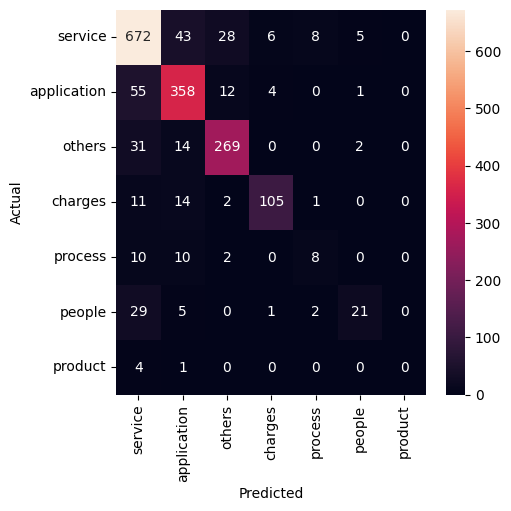

In [203]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(df_test_pred['category_id'], df_test_pred['category_id_pred'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.y.values, yticklabels=category_id_df.y.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [204]:
# Classification report
from sklearn import metrics
print(metrics.classification_report(df_test_pred['category_id'], df_test_pred['category_id_pred'], target_names=df['y'].unique()))

              precision    recall  f1-score   support

     service       0.83      0.88      0.85       762
 application       0.80      0.83      0.82       430
      others       0.86      0.85      0.86       316
     charges       0.91      0.79      0.84       133
     process       0.42      0.27      0.33        30
      people       0.72      0.36      0.48        58
     product       0.00      0.00      0.00         5

    accuracy                           0.83      1734
   macro avg       0.65      0.57      0.60      1734
weighted avg       0.82      0.83      0.82      1734



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

Text(33.222222222222214, 0.5, 'Actual')

Text(0.5, 25.722222222222214, 'Predicted')

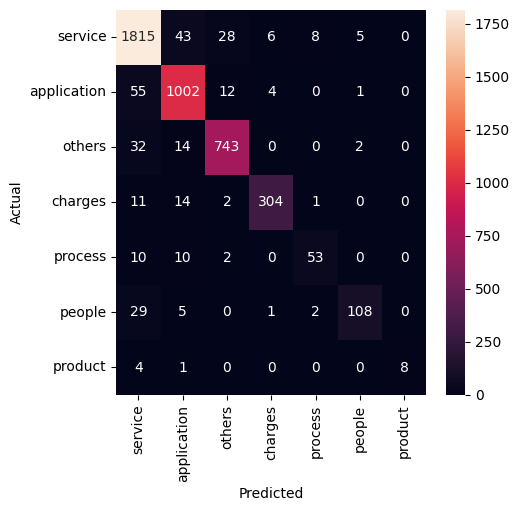

In [205]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(df_pred['category_id'], df_pred['category_id_pred'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.y.values, yticklabels=category_id_df.y.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [206]:
# Classification report overall
from sklearn import metrics
print(metrics.classification_report(df_pred['category_id'], df_pred['category_id_pred'], target_names=df['y'].unique()))

              precision    recall  f1-score   support

     service       0.93      0.95      0.94      1905
 application       0.92      0.93      0.93      1074
      others       0.94      0.94      0.94       791
     charges       0.97      0.92      0.94       332
     process       0.83      0.71      0.76        75
      people       0.93      0.74      0.83       145
     product       1.00      0.62      0.76        13

    accuracy                           0.93      4335
   macro avg       0.93      0.83      0.87      4335
weighted avg       0.93      0.93      0.93      4335



In [208]:
res = pd.DataFrame()
# To manually verify why some failed
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            # print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            temp = df_pred.query(f' (category_id == {actual}) & (category_id_pred == {predicted})')[['x']]
            temp['y'] = id_to_category[actual]
            temp['y_pred'] = id_to_category[predicted]
            # print('')
            res = pd.concat([res,temp])

In [209]:
from google.colab import data_table
data_table.DataTable(res, include_index=False, num_rows_per_page=10)

,x,y,y_pred
100,my demat account relationship manager m abha d...,application,service
205,i like to start my trading so please request y...,application,service
207,no position reflects on screen near about mini...,application,service
213,i am getting very bad experience with your tra...,application,service
726,some time kotak security website run properly,application,service
...,...,...,...
3075,portfolio issue stocktrident share transaction,application,others
3465,graph not updating,application,others
3650,improvement in portal,application,others
3705,mene apne bank se kotak security me transfar d...,application,others


In [210]:
from google.colab import data_table
data_table.DataTable(df_pred.query(' y != y_pred')[['x','y', 'y_pred']], include_index=False, num_rows_per_page=10)

,x,y,y_pred
15,very disappoint about charge no one help for same,charges,service
97,useless it is,others,application
100,my demat account relationship manager m abha d...,application,service
188,yes better support for out of i fia client,people,service
205,i like to start my trading so please request y...,application,service
...,...,...,...
4273,kotak security people doe not take initiative ...,people,service
4286,very heavy and unreasonable penalty applied on...,application,service
4289,charge are high app is not slick,charges,application
4307,hidden chargesxare exorbitantcharges,charges,others
